In [1]:
# Imports
import sklearn
import shap
import numpy as np
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
shap.initjs()

# Preprocess the Data

In [2]:
# Read data
data = pd.read_csv('Dataset-Unicauca-Version2-87Atts-Clean.csv')

In [3]:
# Rename Labels to DataFlow from previous processing that bucketed data usage
data.rename({"labels": "DataFlow"}, axis=1, inplace=True)

In [4]:
# Label Protocol Names to be used as targets for Random Forest Model
lb_make = LabelEncoder()
data["labels"] = lb_make.fit_transform(data["ProtocolName"])
data[["ProtocolName", "labels"]].head(11)
mapped_label_ids = dict(zip(lb_make.classes_,range(len(lb_make.classes_))))

In [5]:
# Drop columns not needed for modelling
data.drop(columns=["Flow.ID"], inplace=True)
data.drop(columns=["ProtocolName"], inplace=True)
data.drop(columns=["L7Protocol"], inplace=True)

In [6]:
# Split Data to train/test
y = data.iloc[:, -1]
data.drop(columns=data.columns[-1], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

# Setup Visualization Labels

In [7]:
# Prepare Interactive Predictive Label Selector for Visualizations
import ipywidgets as widgets
# Create the list of all labels for the drop down list
list_of_labels = y.unique().tolist()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=mapped_label_ids,
                              value=0,
                              description='Select Label:'
                              )
# Create a widget for the labels and then display the widget
current_label2 = widgets.Dropdown(options=mapped_label_ids,
                              value=0,
                              description='Select Label:'
                              )

In [8]:
# Function to report accuracy
def print_accuracy(f):
    print("Accuracy = {0}%".format(100 * np.sum(f(X_test) == y_test) / len(y_test)))
    time.sleep(0.5)  # to let the print get out before any progress bars

# Create Simple Support Vector Machine (SVM) Model

In [9]:
# Support Vector Machine Explainable
svc_linear = sklearn.svm.SVC(kernel='rbf', probability=True)  # linear kernel takes too long, and anything more than 5000 records
svc_linear.fit(X_train.tail(5000), y_train.tail(5000))
print_accuracy(svc_linear.predict)

Accuracy = 30.86699466077768%


# Prepare SHAP Data that Explains the SVM

In [ ]:
# explain all the predictions in the test set
# Use shap.sample on X_train/test like the below because the dataset is too massive; just take a sample
explainer = shap.KernelExplainer(svc_linear.predict_proba, shap.sample(X_train.tail(5000), nsamples=100))
#1000 samples = 260hr computation time, 100 samples = ~2 hrs
shap_values = explainer.shap_values(shap.sample(X_train.tail(5000), nsamples=100))

# Violin Bee-Summary Plot

This is a standard violin plot but with outliers drawn as points. This gives a more accurate representation of the density out the outliers than a kernel density estimated from so few points. The color represents the average feature value at that position, so red regions have mostly high valued feature values while blue regions have mostly low feature values.

In [11]:
current_label

Dropdown(description='Select Label:', options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': 3, 'APPLE…

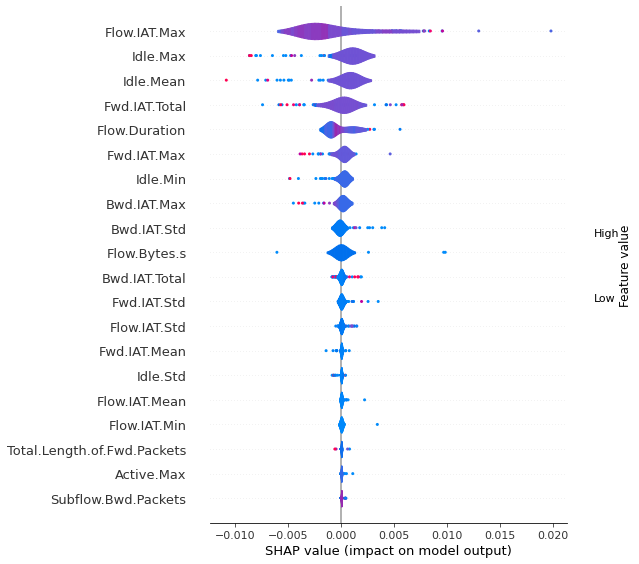

In [12]:
shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = X_test.tail(5000).iloc[0:100,:],
                  plot_type="violin")

By changing the label to something else we can see what features on the left have a higher impact on the model predicting this label. For example, when predicing the Protocol Name of "99TAXI" we see the feature L7Protocol has little importance on predicting this Protocol. However, the feature Forward Packet Length does.

# Stacked Importance Plot

In [13]:
current_label

Dropdown(description='Select Label:', options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': 3, 'APPLE…

In [21]:
shap.force_plot(explainer.expected_value[0], shap_values[current_label.value], shap.sample(X_test.tail(5000), nsamples=1000), link='logit')

Again, by changing the predicted label to something else we can see what features are significant and not significant, like from the previous visualization. However, we cal also interact with different features and compairsons from an additional labels on the top and to the left of the visualization. We can see that when both the highlighted features equal a particular value what the other features we are comparing to on top may equal.

# Visualize a Single Prediction

In [16]:
# See all our predicted values from our X_test dataset.
explainer.expected_value

array([0.02494959, 0.00315304, 0.00099537, 0.00134355, 0.00540107,
       0.00221349, 0.00351092, 0.00103163, 0.00826992, 0.01229334,
       0.25503722, 0.00105855, 0.18861466, 0.09275504, 0.15809284,
       0.00133634, 0.00141466, 0.0143438 , 0.00092046, 0.0043029 ,
       0.0014383 , 0.00119159, 0.0046346 , 0.00888559, 0.00089654,
       0.11654052, 0.00101116, 0.00108329, 0.00095797, 0.00883344,
       0.00103659, 0.00136537, 0.00164156, 0.0100316 , 0.00495372,
       0.05445979])

In [20]:
# View the features that predicted this label
print("Visualization for predicted label: " + str(int(explainer.expected_value[0])))
shap.force_plot(explainer.expected_value[0], shap_values[32], shap.sample(X_test.tail(5000), nsamples=100))

Visualization for predicted label: 0


Now interact with the dropdowns at the top to select the feature and see the values of that feature that may predict the label above.